<img src="https://miro.medium.com/max/2652/1*eTkBMyqdg9JodNcG_O4-Kw.jpeg" width="100%">

[Image Source](https://medium.com/stanford-ai-for-healthcare/its-a-no-brainer-deep-learning-for-brain-mr-images-f60116397472)

# Brain Tumor Auto-Segmentation for Magnetic Resonance Imaging (MRI)

I've built a neural network to automatically segment tumor regions in brain, using [MRI (Magnetic Resonance Imaging](https://en.wikipedia.org/wiki/Magnetic_resonance_imaging)) scans.

The MRI scan is one of the most common image modalities that we encounter in the radiology field.  
Other data modalities include: 
- [Computer Tomography (CT)](https://en.wikipedia.org/wiki/CT_scan), 
- [Ultrasound](https://en.wikipedia.org/wiki/Ultrasound)
- [X-Rays](https://en.wikipedia.org/wiki/X-ray). 

In this notebook, I've covered following topics:

-   What is in an MR image
-   Standard data preparation techniques for MRI datasets
-   Metrics and loss functions for segmentation
-   Visualizing and evaluating segmentation models

## Outline
Use these links to jump to particular sections of this notebook!

- [1. Dataset](#1)
  - [1.1 What is an MRI?](#1-1)
  - [1.2 MRI Data Processing](#1-2)
  - [1.3 Exploring the Dataset](#1-3)
  - [1.4 Data Preprocessing](#1-4)
    - [1.4.1 Sub-volume Sampling](#1-4-1)
    - [1.4.2 Standardization](#1-4-2)
- [2. Model: 3D U-Net](#2)
- [3. Metrics](#3)
  - [3.1 Dice Coefficient](#3-1)
  - [3.2 Soft Dice Loss](#3-2)
- [4. Training](#4)
- [5. Evaluation](#5)
  - [5.1 Overall Performance](#5-1)
  - [5.2 Patch-level Predictions](#5-2)
  - [5.3 Running on Entire Scans](#5-3)

## Packages

In this notebook, I've made use of the following packages:

- `keras` is a framework for building deep learning models.
- `keras.backend` allows us to perform math operations on tensors.
- `nibabel` will let us extract the images and labels from the files in our dataset.
- `numpy` is a library for mathematical and scientific operations.
-  `pandas` is what we'll use to manipulate our data.

## Import Packages

Lets import all the necessary packages, dependencies and custom util functions.

In [1]:
import keras
import json
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

from tensorflow.keras import backend as K 

# watch for any changes in the util_train_model and util_visualize_image modules
# and reload them automatically
%load_ext autoreload
%autoreload 2

import util_visualize
import util_preprocess
import util_train
import util_evaluate

Using TensorFlow backend.


<a name="1"></a>
# 1 Dataset
<a name="1-1"></a>
## 1.1 What is an MRI?

Magnetic resonance imaging (MRI) is an advanced imaging technique that is used to observe a variety of diseases and parts of the body. 

As we will see later, neural networks can analyze these images individually (as a radiologist would) or combine them into a single 3D volume to make predictions.

At a high level, MRI works by measuring the radio waves emitting by atoms subjected to a magnetic field. 

<img src="https://miro.medium.com/max/1740/1*yC1Bt3IOzNv8Pp7t1v7F1Q.png">

In this notebook, I'll walk you through a multi-class segmentation model that I've built to identify 3 different abnormalities in each image: edemas, non-enhancing tumors, and enhancing tumors.

<a name="1-2"></a>

## 1.2 MRI Data Processing

We often encounter MRIs in the [DICOM format](https://en.wikipedia.org/wiki/DICOM). 
- The DICOM format is the output format for most commercial MRI scanners. This type of data can be processed using the [pydicom](https://pydicom.github.io/pydicom/stable/getting_started.html) Python library. 

I've used the data from the [Decathlon 10 Challenge](https://decathlon-10.grand-challenge.org) to train my model.

<a name="1-3"></a>
## 1.3 Exploring the Dataset

The original dataset is stored in the [NifTI-1 format](https://nifti.nimh.nih.gov/nifti-1/). I've used the [NiBabel library](https://github.com/nipy/nibabel) to interact with the files. Each training sample is composed of two separate files:

The first file is an image file containing a 4D array of MR image in the shape of (240, 240, 155, 4). 
-  The first 3 dimensions are the X, Y, and Z values for each point in the 3D volume, which is commonly called a voxel. 
- The 4th dimension is the values for 4 different sequences
    - 0: FLAIR: "Fluid Attenuated Inversion Recovery" (FLAIR)
    - 1: T1w: "T1-weighted"
    - 2: t1gd: "T1-weighted with gadolinium contrast enhancement" (T1-Gd)
    - 3: T2w: "T2-weighted"

The second file in each training example is a label file containing a 3D array with the shape of (240, 240, 155).  
- The integer values in this array indicate the "label" for each voxel in the corresponding image files:
    - 0: background
    - 1: edema
    - 2: non-enhancing tumor
    - 3: enhancing tumor

There are a total of 484 images in the dataset which I've splitted it into training (80%) and validation (20%) datasets.

Let's begin by looking at one single case and visualizing the data! The `load_case` function below uses the [NiBabel library](https://nipy.org/nibabel/nibabel_images.html) to load the image. Then, `get_labeled_image()` function is used to label it. Finally, `plot_image_grid()` function is used to plot the image. The colors correspond to each class, as described below:
- Red is edema
- Green is a non-enhancing tumor
- Blue is an enhancing tumor. 

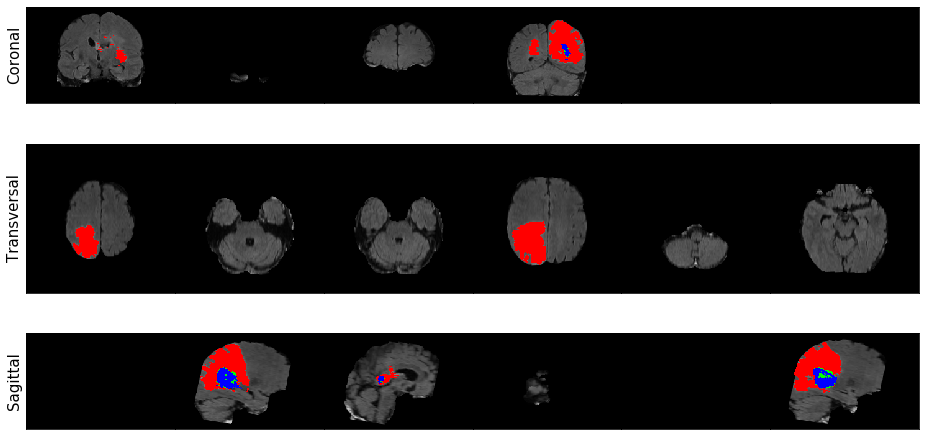

In [2]:
# set home directory and data directory
HOME_DIR = "./BraTS-Data/"
DATA_DIR = HOME_DIR

image_file = DATA_DIR + "imagesTr/BRATS_003.nii.gz"
label_file = DATA_DIR + "labelsTr/BRATS_003.nii.gz"

image, label = util_visualize.load_case(image_file, label_file)
image = util_visualize.get_labeled_image(image, label)

util_visualize.plot_image_grid(image)

# Three cross-sections through brain
<hr/>

<img src="brain_sections.png" width="50%" align="center">


<a name="1-4"></a>
## 1.4 Data Preprocessing using patches

##### Generate sub-volumes

For following reasons, I first generated "patches" of the MRI, which can be thought of as sub-volumes of the whole MR images. 
- The  first reason is that it was not possible to fit the model into the memory, if the model was to be built based on the entire volume of the MRI at once. It is a common issue in building deep neural networks for MRI segmentation. Thus, I generated spatially consistent sub-volumes of the data by randomly sampling sub-volumes of shape \[160, 160, 16\] from the images. 
- However, given that a large portion of the MRI volumes are just brain tissue or black background without any tumors, I wanted to make sure that I picked patches that at least included some amount of tumor data. Therefore, I picked patches that have at most 95% non-tumor regions (so at least 5% tumor). I did this by filtering the volumes based on the values present in the background labels.

##### Standardization (mean 0, stdev 1)

Lastly, given that the values in MR images cover a very wide range, I standardized the values to have a mean of zero and standard deviation of 1. 
- This is a common technique in deep image processing since standardization makes it much easier for the network to learn.

Let's walk through these steps in the following exercises.

<a name="1-4-1"></a>
### 1.4.1 Sub-volume Sampling
I wrote the `get_sub_volume()` function in `util_preprocess` to perform sub-volume sampling. For the present model, the function takes in images and labels with following dimensions: 
- a 4D image (shape: \[240, 240, 155, 4\])
- its 3D label (shape: \[240, 240, 155\]) arrays, 

and returns:
 - A randomly generated sub-volume of size \[160, 160, 16\]
 - Its corresponding label in a 1-hot format which has the shape \[3, 160, 160, 16\]

Additionally: 
1. As I stated before, at most 95% of the returned patch has non-tumor regions. 
2. The dimensions of the image are reordered to have the channels appear as the first dimension, to be compatible with the requirements of the 3D-UNet network.
3. The dimensions of the label array are reordered to have the first dimension as the classes, instead of the last one. 
4. The labels array's dimensions are reduced to only include the non-background classes (total of 3 instead of 4)

### Test Case:

In [3]:
np.random.seed(3)

image = np.zeros((4, 4, 3, 1))
label = np.zeros((4, 4, 3))
for i in range(4):
    for j in range(4):
        for k in range(3):
            image[i, j, k, 0] = i*j*k
            label[i, j, k] = k

print("\nimage:")
for k in range(3):
    print(f"z = {k}")
    print(image[:, :, k, 0])
print("\n")
print("label:")
for k in range(3):
    print(f"z = {k}")
    print(label[:, :, k])
    
# Extracting (2, 2, 2) sub-volume    
sample_image, sample_label = \
    util_preprocess.get_sub_volume(image, label,                                   
                                   orig_x=4, orig_y=4, orig_z=3,                                                                      
                                   output_x=2, output_y=2, output_z=2,                                                                      
                                   num_classes=3)

print("\nSampled Image:")
for k in range(2):
    print("z = " + str(k))
    print(sample_image[0, :, :, k])  
    
print("\nSampled Label:")
for c in range(2):
    print("class = " + str(c))
    for k in range(2):
        print("z = " + str(k))
        print(sample_label[c, :, :, k])    


image:
z = 0
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
z = 1
[[0. 0. 0. 0.]
 [0. 1. 2. 3.]
 [0. 2. 4. 6.]
 [0. 3. 6. 9.]]
z = 2
[[ 0.  0.  0.  0.]
 [ 0.  2.  4.  6.]
 [ 0.  4.  8. 12.]
 [ 0.  6. 12. 18.]]


label:
z = 0
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
z = 1
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
z = 2
[[2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]]

Sampled Image:
z = 0
[[0. 2.]
 [0. 3.]]
z = 1
[[0. 4.]
 [0. 6.]]

Sampled Label:
class = 0
z = 0
[[1. 1.]
 [1. 1.]]
z = 1
[[0. 0.]
 [0. 0.]]
class = 1
z = 0
[[0. 0.]
 [0. 0.]]
z = 1
[[1. 1.]
 [1. 1.]]


Let's look at a candidate patch and ensure that the function works correctly. The image on the left shows the enhancing tumor label.

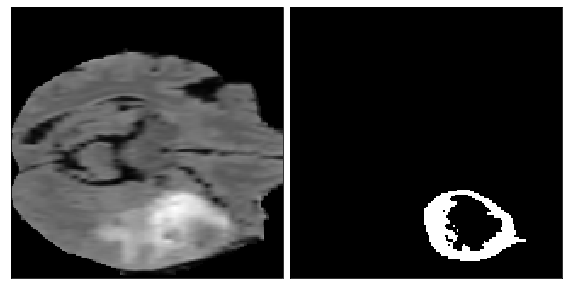

In [4]:
image_file = DATA_DIR + "imagesTr/BRATS_001.nii.gz"
label_file = DATA_DIR + "labelsTr/BRATS_001.nii.gz"

image, label = util_visualize.load_case(image_file, label_file)
image
X, y = util_preprocess.get_sub_volume(image, label,max_tries = 1000)
# enhancing tumor is channel 2 in the class label
# changing the indexer for y would show different classes
util_visualize.visualize_patch(X[0, :, :, :], y[2])

<a name="1-4-2"></a>
### 1.4.2 Standardization

`standardize(patch)` function from `util_preprocess` module takes in a patch (sub-volume), and standardizes it so that the values across each channel and each Z plane have a mean of zero and standard deviation of 1. 

### Test Case:

In [5]:
X_norm = util_preprocess.standardize(X)
print("standard deviation for a slice should be 1.0")
print(f"stddv for X_norm[0, :, :, 0]: {X_norm[0,:,:,0].std():.2f}")

standard deviation for a slice should be 1.0
stddv for X_norm[0, :, :, 0]: 1.00


<a name="2"></a>
# 2 Model: 3D U-Net
In this project, I've used [3D U-net](https://arxiv.org/abs/1606.06650) architecture to build my model.
- This architecture takes advantage of the volumetric shape of MR images and is one of the best performing models for this task. ( [Ref](https://arxiv.org/abs/1606.06650).)

<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" width="50%">

<a name="3"></a>
# 3 Metrics

<a name="3-1"></a>
## 3.1 Dice Similarity Coefficient

Aside from the architecture, one of the most important elements of any deep learning method is the choice of the loss function. 

The cross-entropy loss function, which is typically used in most classification applications,
is not ideal for segmentation tasks due to their heavy class imbalance (there are typically not many positive regions). 

A much more common loss for segmentation tasks is the Dice similarity coefficient, which is a measure of how well two contours overlap. 
- The Dice index ranges from 0 (complete mismatch) 
- To 1 (perfect match).

In general, for two sets $A$ and $B$, the Dice similarity coefficient is defined as: 
$$\text{DSC}(A, B) = \frac{2 \times |A \cap B|}{|A| + |B|}.$$

<img src="https://www.researchgate.net/publication/328671987/figure/fig4/AS:688210103529478@1541093483784/Calculation-of-the-Dice-similarity-coefficient-The-deformed-contour-of-the-liver-from.ppm" width="30%">

[Image Source](https://www.researchgate.net/figure/Calculation-of-the-Dice-similarity-coefficient-The-deformed-contour-of-the-liver-from_fig4_328671987)

Here we can interpret $A$ and $B$ as sets of voxels, $A$ being the predicted tumor region and $B$ being the ground truth. 

Our model maps each voxel to 0 or 1
- 0 means it is a background voxel
- 1 means it is part of the segmented region.

In the dice coefficient, the variables in the formula are:
- $x$ : the input image
- $f(x)$ : the model output (prediction)
- $y$ : the label (actual ground truth)

However, to have a differetiable loss function, the following dice coefficient "DSC" is used instead:

$$\text{DSC}(f, x, y) = \frac{2 \times \sum_{i, j} f(x)_{ij} \times y_{ij} + \epsilon}{\sum_{i,j} f(x)_{ij} + \sum_{i, j} y_{ij} + \epsilon}$$

- $\epsilon$ is a small number that is added to avoid division by zero

### Dice Coefficient for Multiple classes
The Dice Coefficient for single can be easily extended to multiple class cases. In particular, I want my model to do segementation for each of the 3 classes of abnormality (edema, enhancing tumor, non-enhancing tumor). Thus, the overall dice coefficient is an average over 3 different dice coefficients (one for each abnormality class). 

$$DC(f, x, y) = \frac{1}{3} \left ( DC_{1}(f, x, y) + DC_{2}(f, x, y) + DC_{3}(f, x, y) \right )$$

- $DC_{1}$, $DC_{2}$ and $DC_{3}$ are edema, enhancing tumor, and non-enhancing tumor dice coefficients.

In general, for any number of classes, the equation becomes:  
$$DC(f, x, y) = \frac{1}{C} \sum_{c=1}^{C} \left ( DC_{c}(f, x, y) \right )$$

In this case, with three categories, $C = 3$

Implement the mean dice coefficient below. This should not be very different from your singe-class implementation.

<a name="3-2"></a>
## 3.2 Soft Dice Loss

While the Dice Coefficient makes intuitive sense, it is not the best for training. 
- This is because it takes in discrete values (zeros and ones). 
- The model outputs *probabilities* that each pixel is, say, a tumor or not, and we want to be able to backpropagate through those outputs. 

Therefore, we need an analogue of the Dice loss which takes real valued input. This is where the **Soft Dice loss** comes in. The formula is: 

$$\mathcal{L}_{Dice}(p, q) = 1 - \frac{2\times\sum_{i, j} p_{ij}q_{ij} + \epsilon}{\left(\sum_{i, j} p_{ij}^2 \right) + \left(\sum_{i, j} q_{ij}^2 \right) + \epsilon}$$

- $p$ is our predictions
- $q$ is the ground truth 
- In practice each $q_i$ will either be 0 or 1. 
- $\epsilon$ is a small number that is added to avoid division by zero

The soft Dice loss ranges between 
- 0: perfectly matching the ground truth distribution $q$
- 1: complete mismatch with the ground truth.

For the case that $p_i$ and $q_i$ are each 0 or 1, then the soft Dice loss is just one minus the dice coefficient.


### Multi-Class Soft Dice Loss

For any number of categories of diseases, the expression becomes:

$$\mathcal{L}_{Dice}(p, q) = 1 - \frac{1}{C} \sum_{c=1}^{C} \frac{2\times\sum_{i, j} p_{cij}q_{cij} + \epsilon}{\left(\sum_{i, j} p_{cij}^2 \right) + \left(\sum_{i, j} q_{cij}^2 \right) + \epsilon}$$

#### Test Case 1

In [6]:
# TEST CASES
sess = K.get_session()
with sess.as_default() as sess:
    pred = np.expand_dims(np.expand_dims(np.eye(2), 0), -1)
    label = np.expand_dims(np.expand_dims(np.array([[1.0, 1.0], [0.0, 0.0]]), 0), -1)

    print("Test Case #1")
    print("pred:")
    print(pred[0, :, :, 0])
    print("label:")
    print(label[0, :, :, 0])

    dc = util_evaluate.soft_dice_loss(pred, label, epsilon=1)
    print(f"soft dice loss:{dc.eval():.4f}")

Test Case #1
pred:
[[1. 0.]
 [0. 1.]]
label:
[[1. 1.]
 [0. 0.]]
soft dice loss:0.4000


<a name="4"></a>
# 4 Create and Train the model

Once you've finished implementing the soft dice loss, we can create the model! 

We'll use the `unet_model_3d` function in `utils` which we implemented for you.
- This creates the model architecture and compiles the model with the specified loss functions and metrics. 
- Check out function `util.unet_model_3d(loss_function)` in the `util.py` file.

In [7]:
model = util_train.unet_model_3d(loss_function=util_evaluate.soft_dice_loss, 
                                 metrics=[util_evaluate.dice_coefficient])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


<a name="4-1"></a>
## 4.1 Training on a Large Dataset

In order to facilitate the training on the large dataset:
- I've used `VolumeDataGenerator` class in `util_train.py`, which inherits from Keras [`Sequence`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence) class. The latter is created to be used as a `Generator` for the keras model to train on large datasets. Then, I used fit_generator to fit the model. 

In [8]:
# base_dir = HOME_DIR + "processed/"

# with open(base_dir + "config.json") as json_file:
#     config = json.load(json_file)

# # Get generators for training and validation sets
# train_generator = util_train.VolumeDataGenerator(config["train"], base_dir + "train/", batch_size=3, dim=(160, 160, 16), verbose=0)
# valid_generator = util_train.VolumeDataGenerator(config["valid"], base_dir + "valid/", batch_size=3, dim=(160, 160, 16), verbose=0)

# steps_per_epoch = 20
# n_epochs=20
# validation_steps = 20

# model.fit_generator(generator=train_generator,
#         steps_per_epoch=steps_per_epoch,
#         epochs=n_epochs,
#         use_multiprocessing=True,
#         validation_data=valid_generator,
#         validation_steps=validation_steps)

# model.save_weights(base_dir + 'my_model_pretrained.hdf5')

<a name="4-2"></a>
## 4.2 Loading the Trained Model

In [9]:
base_dir = HOME_DIR + "processed/"
with open(base_dir + "config.json") as json_file:
    config = json.load(json_file)
# Get generators for training and validation sets
train_generator = util_train.VolumeDataGenerator(config["train"], base_dir + "train/", batch_size=3, dim=(160, 160, 16), verbose=0)
valid_generator = util_train.VolumeDataGenerator(config["valid"], base_dir + "valid/", batch_size=3, dim=(160, 160, 16), verbose=0)

In [10]:
model.load_weights(HOME_DIR + "model_pretrained.hdf5")

In [11]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 4, 160, 160,  0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 32, 160, 160, 3488        input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 160, 160, 0           conv3d_1[0][0]                   
__________________________________________________________________________________________________
conv3d_2 (Conv3D)               (None, 64, 160, 160, 55360       activation_1[0][0]               
____________________________________________________________________________________________

<a name="5"></a>
# 5 Evaluation

Now that we have a trained model, we'll learn to extract its predictions and evaluate its performance on scans from our validation set.

<a name="5-2"></a>
## 5.1 Patch-level predictions

When applying the model, we'll want to look at segmentations for individual scans (entire scans, not just the sub-volumes)
- This will be a bit complicated because of our sub-volume approach. 
- First let's keep things simple and extract model predictions for sub-volumes.
- We can use the sub-volume which we extracted at the beginning of the assignment.

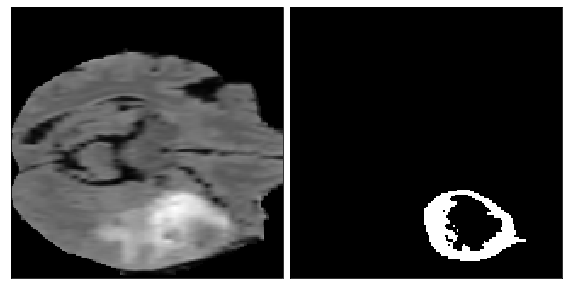

In [12]:
util_visualize.visualize_patch(X_norm[0, :, :, :], y[2])

#### Add a 'batch' dimension
We can extract predictions by calling `model.predict` on the patch. 
- We'll add an `images_per_batch` dimension, since the `predict` method is written to take in batches. 
- The dimensions of the input should be `(images_per_batch, num_channels, x_dim, y_dim, z_dim)`.
- Use [numpy.expand_dims](https://docs.scipy.org/doc/numpy/reference/generated/numpy.expand_dims.html) to add a new dimension as the zero-th dimension by setting axis=0

In [13]:
X_norm_with_batch_dimension = np.expand_dims(X_norm, axis=0)
patch_pred = model.predict(X_norm_with_batch_dimension)

#### Convert prediction from probability into a category
Currently, each element of `patch_pred` is a number between 0.0 and 1.0.
- Each number is the model's confidence that a voxel is part of a given class. 
- We'll convert these to discrete 0 and 1 integers by using a threshold (here, 0.5)

In [14]:
# set threshold.
threshold = 0.5

# use threshold to get hard predictions
patch_pred[patch_pred > threshold] = 1.0
patch_pred[patch_pred <= threshold] = 0.0

Now let's visualize the original patch and ground truth alongside our thresholded predictions.

Patch and ground truth


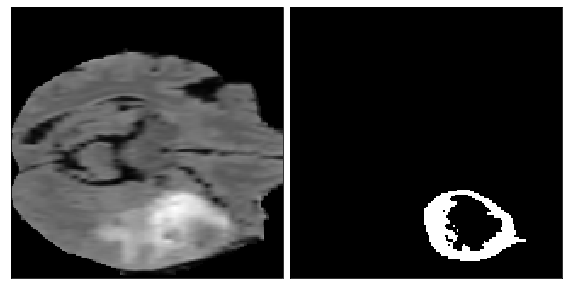

Patch and prediction


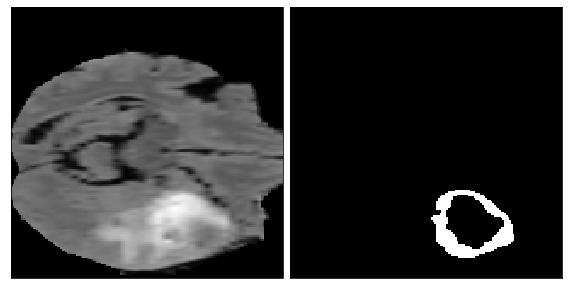

In [15]:
print("Patch and ground truth")
util_visualize.visualize_patch(X_norm[0, :, :, :], y[2])
plt.show()
print("Patch and prediction")
util_visualize.visualize_patch(X_norm[0, :, :, :], patch_pred[0, 2, :, :, :])
plt.show()

#### Sensitivity and Specificity

The model is covering some of the relevant areas, but it's definitely not perfect. 
- To quantify its performance, we can use per-pixel sensitivity and specificity. 

Recall that in terms of the true positives, true negatives, false positives, and false negatives, 

$$\text{sensitivity} = \frac{\text{true positives}}{\text{true positives} + \text{false negatives}}$$

$$\text{specificity} = \frac{\text{true negatives}}{\text{true negatives} + \text{false positives}}$$

`compute_class_sens_spec` function in `util_evaluate` module computes the sensitivity and specificity per output class.

In [16]:
from IPython.display import display

df = pd.DataFrame({'y_test': [1,1,0,0,0,0,0,0,0,1,1,1,1,1],
                   'preds_test': [1,1,0,0,0,1,1,1,1,0,0,0,0,0],
                   'category': ['TP','TP','TN','TN','TN','FP','FP','FP','FP','FN','FN','FN','FN','FN']
                  })

display(df)
pred = np.array( [df['preds_test']])
label = np.array( [df['y_test']])

sensitivity, specificity = util_evaluate.compute_class_sens_spec(pred, label, 0)
print(f"sensitivity: {sensitivity:.4f}")
print(f"specificity: {specificity:.4f}")

,y_test,preds_test,category
0,1,1,TP
1,1,1,TP
2,0,0,TN
3,0,0,TN
4,0,0,TN
5,0,1,FP
6,0,1,FP
7,0,1,FP
8,0,1,FP
9,1,0,FN


sensitivity: 0.2857
specificity: 0.4286


#### Expected Output

```Python
...
sensitivity: 0.2857
specificity: 0.4286
```

#### Sensitivity and Specificity for the patch prediction

Next let's compute the sensitivity and specificity on that patch for expanding tumors. 

In [17]:
sensitivity, specificity = util_evaluate.compute_class_sens_spec(patch_pred[0], y, 2)

print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

Sensitivity: 0.7891
Specificity: 0.9960


Lets look at the sensitivity and specificity for each class, using `get_sens_spec_df(pred, label)` function from `util_evaluate` module.

In [18]:
df = util_evaluate.get_sens_spec_df(patch_pred[0], y)

print(df)

              Edema Non-Enhancing Tumor Enhancing Tumor
Sensitivity  0.9085              0.9505          0.7891
Specificity  0.9848              0.9961           0.996


<a name="5-3"></a>
## 5.2 Running on entire scans
I take one step further to put together the model predictions over patches to see the result on a whole MRI scan. To accomplish this,

- First, I generate patches for the scan.
- Then I run the model on the patches. 
- Then I combine the results together to get a fully labeled MR image.

The output of my model will be a 4D array with 3 probability values for each voxel in our data. 
- We then can use a threshold (which can be found by a calibration process) to decide whether or not to report a label for each voxel. 

`predict_and_viz(image, label, model, threshold)` function in `util_trail` module stitches together the predictions of the lables for voxels.
- Inputs: an image, label and model.
- Ouputs: the model prediction over the whole image, and a visual of the ground truth and prediction. 

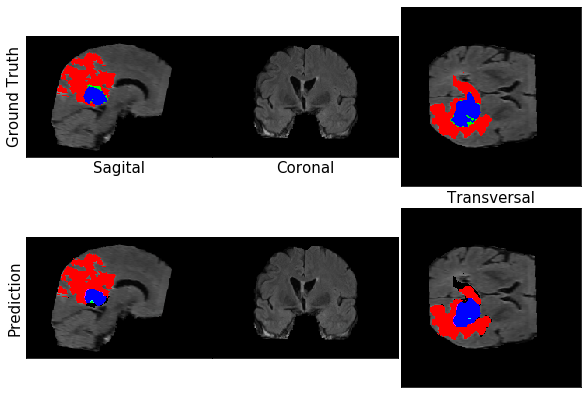

In [20]:
image_file = DATA_DIR + "imagesTr/BRATS_003.nii.gz"
image_label = DATA_DIR + "labelsTr/BRATS_003.nii.gz"
image, label = util_visualize.load_case(image_file, image_label)
pred = util_train.predict_and_viz(image, label, model, .5, loc=(130, 130, 77))                

#### Check how well the predictions do

In [23]:
# format the label and prediction to match our functions expect.
whole_scan_label = keras.utils.to_categorical(label, num_classes = 4)
whole_scan_pred = pred

# move axis to match shape expected in functions
whole_scan_label = np.moveaxis(whole_scan_label, 3 ,0)[1:4]
whole_scan_pred = np.moveaxis(whole_scan_pred, 3, 0)[1:4]

# compute sensitivity and specificity for each class
whole_scan_df = util_evaluate.get_sens_spec_df(whole_scan_pred, whole_scan_label)

print(whole_scan_df)

              Edema Non-Enhancing Tumor Enhancing Tumor
Sensitivity   0.902              0.2617          0.8496
Specificity  0.9894              0.9998          0.9982


# That's all for now!
Thanks for walking through this notebook with me!



